In [1]:
import torch
import torch.nn as nn
from timm.layers import DropPath, to_2tuple, trunc_normal_

/home/ubuntu/omer-training/.omer-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
# Load the image file
image_path = '/home/ubuntu/omer-training/data/test/Major Damage/68539_107962_18.jpg'
image = Image.open(image_path)

In [4]:
test_image_path = '/home/ubuntu/omer-training/data/test/Major Damage/68539_107962_18.jpg'
size_i = 448
res_i = 112

In [5]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((size_i, size_i)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

In [6]:
# Apply the transformation to the image
tensor_image = transform(image)

In [7]:
# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

In [8]:
# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

Tensor shape: torch.Size([1, 3, 448, 448])
Tensor data type: torch.float32


In [9]:
# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)

In [10]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches

In [11]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

'''# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()'''

Windows shape: torch.Size([12544, 4, 4, 3])
num_patches  12544


'# Calculate the number of rows and columns in the grid\nnum_rows = int(num_patches ** 0.5)\nnum_cols = num_patches // num_rows\n\n# Create a subplot grid\nfig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))\n\n# Iterate over the patches and plot them\nfor i, ax in enumerate(axs.flat):\n    patch = windows[i].numpy()\n    ax.imshow(patch)\n    ax.axis("off")\n\n# Adjust the spacing between subplots\nplt.tight_layout()\n\n# Show the plot\nplt.show()'

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
"""for i in range(num_windows):
    window = windows[i]  # Get a single window
    
    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)
    
    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
    
    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()"""

Total number of windows: 12544


"for i in range(num_windows):\n    window = windows[i]  # Get a single window\n    \n    # Convert the window tensor to a numpy array and transpose dimensions\n    window_np = window.numpy().transpose(1, 0, 2)\n    \n    # Normalize the window values to [0, 1] range\n    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())\n    \n    # Display the window image\n    plt.imshow(window_np)\n    plt.axis('off')\n    plt.show()"

In [13]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=528, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

In [14]:
# Load the image file
image_path = test_image_path
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((size_i, size_i)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=size_i, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image) 
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 12544, 96])


tensor([[[-0.1857,  0.1371, -0.1577,  ..., -0.1809, -0.0290, -0.0107],
         [-0.1667,  0.2362, -0.1880,  ..., -0.1607, -0.0948, -0.0724],
         [-0.1997,  0.2088, -0.1850,  ..., -0.1280, -0.0694, -0.0695],
         ...,
         [-0.2005,  0.2084, -0.1791,  ..., -0.1832, -0.0577, -0.1040],
         [-0.2074,  0.2112, -0.1756,  ..., -0.1811, -0.0651, -0.1178],
         [-0.2192,  0.2127, -0.1910,  ..., -0.1788, -0.0615, -0.1221]]],
       grad_fn=<TransposeBackward0>)

In [15]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([-0.1857,  0.1371, -0.1577, -0.0012,  0.1082, -0.2858,  0.2463, -0.0574,
         0.0306, -0.4534, -0.2061, -0.1360, -0.0645,  0.1558, -0.1205, -0.0793,
         0.0642,  0.1707,  0.0578, -0.0855,  0.0778, -0.0145,  0.1504, -0.6096,
        -0.0270, -0.3742,  0.2474, -0.0660,  0.0779,  0.3483, -0.1830, -0.1464,
        -0.1236, -0.2734,  0.2085,  0.0668,  0.2185, -0.0486,  0.2535,  0.1211,
         0.2451,  0.3278, -0.0183, -0.3479,  0.2641, -0.0453, -0.0947, -0.3271,
         0.1183, -0.1536,  0.0170,  0.1684,  0.3239,  0.0514,  0.2994, -0.1901,
         0.2072,  0.0856, -0.0901, -0.2702,  0.0144, -0.3427,  0.1597, -0.2110,
         0.0119, -0.2144,  0.0540, -0.3504,  0.1341, -0.1222,  0.2805, -0.1697,
        -0.1005,  0.0297,  0.1312,  0.0137,  0.0545,  0.2266, -0.0092,  0.0224,
        -0.0492,  0.5049,  0.1621, -0.0943,  0.2156, -0.0139, -0.1149, -0.1018,
         0.4811, -0.1081,  0.0355, -0.0192, -0.0944, -0.1809, -0.0290, -0.0107],
       gr

In [16]:
from swin_functions_and_classes import BasicLayer, PatchMerging, SwinTransformerBlock,SwinTransformer


stage_1 = BasicLayer(dim=96, input_resolution=(res_i, res_i), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

/home/ubuntu/omer-training/.omer-env/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 12544, 96])


tensor([[[-0.2292,  0.0580, -0.5002,  ...,  0.3637, -0.1931,  0.2086],
         [-0.2722,  0.1707, -0.5023,  ...,  0.4006, -0.2245,  0.1205],
         [-0.2058,  0.2170, -0.4258,  ...,  0.4681, -0.2412,  0.1451],
         ...,
         [-0.1548,  0.0923, -0.5188,  ...,  0.3155, -0.0924,  0.0995],
         [-0.1648,  0.0961, -0.5116,  ...,  0.3252, -0.0982,  0.0774],
         [-0.1926,  0.0790, -0.5414,  ...,  0.3020, -0.0963,  0.0946]]],
       grad_fn=<AddBackward0>)

In [17]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(res_i, res_i), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

#Merged output shape: torch.Size([1, 784, 192])


Merged output shape: torch.Size([1, 3136, 192])


In [18]:

batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)



Batch size: 1
Number of patches: 3136
Number of channels: 192


In [19]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(res_i, res_i), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(res_i, res_i), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 12544, 96])
torch.Size([1, 12544, 96])
tensor([[[-0.2478,  0.6376, -0.2630,  ..., -0.0039, -0.8764,  0.1809],
         [-0.2347,  0.7435, -0.3140,  ...,  0.0477, -0.9244,  0.1136],
         [-0.3228,  0.6658, -0.3345,  ...,  0.0461, -0.8948,  0.0657],
         ...,
         [-0.3098,  0.7658, -0.2458,  ..., -0.0253, -0.8824,  0.0214],
         [-0.3144,  0.7726, -0.2506,  ..., -0.0266, -0.8881,  0.0099],
         [-0.3183,  0.7699, -0.2542,  ..., -0.0177, -0.8818,  0.0144]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.2539,  0.2418, -0.3083,  ..., -0.4869,  0.2788,  0.0622],
         [ 0.2612,  0.3398, -0.3413,  ..., -0.4932,  0.1652,  0.0593],
         [ 0.1471,  0.2542, -0.3653,  ..., -0.4415,  0.1524, -0.0057],
         ...,
         [ 0.1995,  0.3816, -0.2525,  ..., -0.4297,  0.1499, -0.0449],
         [ 0.1876,  0.3805, -0.2522,  ..., -0.4394,  0.1408, -0.0516],
         [ 0.1696,  0.4027, -0.2532,  ..., -0.4230,  0.1554, -0.0618]]],
       grad_fn=<AddBackward0>)


In [20]:
model = SwinTransformer(img_size = size_i)

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 448, 448])


torch.Size([1, 1000])

In [21]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "data", "train")
test_dir = os.path.join(current_directory, "data", "test")


In [22]:
from setup_model import engine,data_setup

In [23]:
# Create image size
IMG_SIZE = size_i

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")



Manually created transforms: Compose(
    Resize(size=(448, 448), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [24]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa18c8d7f70>,
 ['Major Damage', 'Minor Damage', 'No Damage'])

torch.Size([3, 448, 448]) tensor(1)


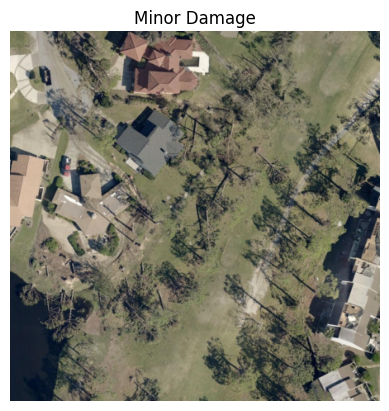

In [25]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [26]:
model = SwinTransformer(num_classes=len(class_names),img_size=size_i)

In [27]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()
save_path = "/home/ubuntu/omer-training/swin_T_model_2"


In [28]:
#latest_weight = '/home/ubuntu/omer-training/swin_T_model_2/eff_model_weights-best_0_015.pth' 
latest_weight = None

In [29]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=30,
                       device=device,
                       latest_weigths=latest_weight,
                       save_path=save_path,
                       save_epoch= 5)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 95.06 MiB is free. Process 8849 has 5.60 GiB memory in use. Including non-PyTorch memory, this process has 9.04 GiB memory in use. Of the allocated memory 8.77 GiB is allocated by PyTorch, and 157.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from visualize import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [ ]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)